In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
from scipy.misc import imresize

#%matplotlib inline

import os
from os import listdir
from os.path import isfile, join
import shutil
import stat
import collections
from collections import defaultdict

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

import h5py
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
#from keras.applications.inception_v3 import preprocess_input
from keras.models import load_model

Using TensorFlow backend.


In [2]:
import tensorflow as tf
tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)

True

In [3]:
class_to_ix = {}
ix_to_class = {}
with open('food-101/meta/classes.txt', 'r') as txt:
    classes = [l.strip() for l in txt.readlines()]
    class_to_ix = dict(zip(classes, range(len(classes))))
    ix_to_class = dict(zip(range(len(classes)), classes))
    class_to_ix = {v: k for k, v in ix_to_class.items()}
sorted_class_to_ix = collections.OrderedDict(sorted(class_to_ix.items()))

In [4]:
classes

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [5]:
nb_classes = len(classes)

#### seperate train and test files copied

In [6]:
if not os.path.isdir('./food-101/test') and not os.path.isdir('./food-101/train'):

    def copytree(src, dst, symlinks = False, ignore = None):
        if not os.path.exists(dst):
            os.makedirs(dst)
            shutil.copystat(src, dst)
        lst = os.listdir(src)
        if ignore:
            excl = ignore(src, lst)
            lst = [x for x in lst if x not in excl]
        for item in lst:
            s = os.path.join(src, item)
            d = os.path.join(dst, item)
            if symlinks and os.path.islink(s):
                if os.path.lexists(d):
                    os.remove(d)
                os.symlink(os.readlink(s), d)
                try:
                    st = os.lstat(s)
                    mode = stat.S_IMODE(st.st_mode)
                    os.lchmod(d, mode)
                except:
                    pass # lchmod not available
            elif os.path.isdir(s):
                copytree(s, d, symlinks, ignore)
            else:
                shutil.copy2(s, d)

    def generate_dir_file_map(path):
        dir_files = defaultdict(list)
        with open(path, 'r') as txt:
            files = [l.strip() for l in txt.readlines()]
            for f in files:
                dir_name, id = f.split('/')
                dir_files[dir_name].append(id + '.jpg')
        return dir_files

    train_dir_files = generate_dir_file_map('food-101/meta/train.txt')
    test_dir_files = generate_dir_file_map('food-101/meta/test.txt')


    def ignore_train(d, filenames):
        print(d)
        subdir = d.split('/')[-1]
        to_ignore = train_dir_files[subdir]
        return to_ignore

    def ignore_test(d, filenames):
        print(d)
        subdir = d.split('/')[-1]
        to_ignore = test_dir_files[subdir]
        return to_ignore

    copytree('food-101/images', 'food-101/test', ignore=ignore_train)
    copytree('food-101/images', 'food-101/train', ignore=ignore_test)
    
else:
    print('Train/Test files already copied into separate folders.')

Train/Test files already copied into separate folders.


In [7]:
%%time

# Load dataset images and resize to meet minimum width and height pixel size
def load_images(root):
    all_imgs = []
    all_classes = []
    resize_count = 0
    invalid_count = 0
    for i, subdir in enumerate(listdir(root)):
        imgs = listdir(join(root, subdir))
        class_ix = class_to_ix[subdir]
        print(i, class_ix, subdir)
        for img_name in imgs:
            img_arr = img.imread(join(root, subdir, img_name))
            #img_arr_rs = img_arr
    return np.array(img_arr), np.array(class_ix)

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 10.5 µs


In [7]:
nb_train_samples = 75750
nb_validation_samples = 25250
img_width, img_height = 224, 224  # make the loaded imgs with same size

#### a very easy way to normalize the imgs in files

In [8]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1.0 / 255, zoom_range=0.2, horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

In [9]:
train_data_dir = './food-101/train'
validation_data_dir = './food-101/test'

In [11]:
train_generator = train_datagen.flow_from_directory(
  train_data_dir,
  target_size=(img_width, img_height),
  color_mode='rgb',
  classes=classes,
  class_mode='categorical',
  batch_size=32)

validation_generator = validation_datagen.flow_from_directory(
  validation_data_dir,
  target_size=(img_width, img_height),
  color_mode='rgb',
  classes=classes,
  class_mode='categorical',
  batch_size=32)


Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.


#### build model

In [12]:
from keras.applications.resnet50 import ResNet50
from keras.models import Sequential, Model
from keras.layers import Input, Flatten, Dense

In [13]:
input_tensor = Input(shape=(img_width, img_height, 3)) # assign 224*224 as input tensor
ResNet50 = ResNet50(include_top=False, weights='imagenet',input_tensor=input_tensor) # pre-trained resnet model

/home/partners/anaconda3/envs/py36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [14]:
top_model = Sequential() # create new sequential instead of delete one
top_model.add(Flatten(input_shape=ResNet50.output_shape[1:])) # 1D output of resnet50
top_model.add(Dense(nb_classes, activation='softmax')) # give the output of last step to the dense with all classes

In [15]:
model = Model(inputs=ResNet50.input, outputs=top_model(ResNet50.output))

#### use stochastic gradient descent as optimization algorithm and make the model learn

In [16]:
from keras import optimizers
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-3, momentum=0.9),
              metrics=['accuracy'])

#### sample per epoch is the number of train samples, so each epoch uses 75750 samples. Because of 64 batch size,   the step of each epoch is 75750/64

In [17]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=None,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples/32,
    workers=1, 
    use_multiprocessing=False)

Epoch 1/10
2368/2368 [==============================] - 4481s 2s/step - loss: 2.5543 - acc: 0.4212 - val_loss: 1.5851 - val_acc: 0.5908
Epoch 2/10
2368/2368 [==============================] - 2258s 954ms/step - loss: 1.2696 - acc: 0.6685 - val_loss: 1.4671 - val_acc: 0.6215
Epoch 3/10
2368/2368 [==============================] - 2259s 954ms/step - loss: 0.8391 - acc: 0.7731 - val_loss: 1.3730 - val_acc: 0.6526
Epoch 4/10
2368/2368 [==============================] - 2259s 954ms/step - loss: 0.5657 - acc: 0.8420 - val_loss: 1.3077 - val_acc: 0.6800
Epoch 5/10
2368/2368 [==============================] - 2259s 954ms/step - loss: 0.3966 - acc: 0.8871 - val_loss: 1.4522 - val_acc: 0.6679
Epoch 6/10
2368/2368 [==============================] - 2259s 954ms/step - loss: 0.2768 - acc: 0.9205 - val_loss: 1.4685 - val_acc: 0.6703
Epoch 7/10
2368/2368 [==============================] - 2259s 954ms/step - loss: 0.2050 - acc: 0.9395 - val_loss: 1.4998 - val_acc: 0.6785
Epoch 8/10
2368/2368 [========

#### test dataset img prediction

In [18]:
from keras.preprocessing import image
import numpy as np
 
image_data = './food-101/test/chicken_wings/1010547.jpg'
img = image.load_img(image_data, target_size=(img_width, img_height))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255
pred = model.predict(x)[0]

top = 101
top_indices = pred.argsort()[-top:][::-1]
result = [(classes[i], pred[i]) for i in top_indices]
print(result)

[('chicken_wings', 0.9999535), ('peking_duck', 4.3073833e-05), ('fish_and_chips', 3.3478734e-06), ('churros', 3.1455336e-08), ('chicken_curry', 1.8989681e-08), ('lasagna', 8.30668e-09), ('spring_rolls', 6.13221e-09), ('eggs_benedict', 4.8214317e-09), ('fried_calamari', 2.4278342e-09), ('baby_back_ribs', 2.2479847e-09), ('pulled_pork_sandwich', 1.894781e-09), ('sushi', 1.5989016e-09), ('donuts', 1.4914264e-09), ('dumplings', 1.4566164e-09), ('crab_cakes', 1.3304626e-09), ('chicken_quesadilla', 1.2434102e-09), ('hamburger', 1.2396852e-09), ('poutine', 1.0681966e-09), ('grilled_salmon', 8.284493e-10), ('french_toast', 6.628486e-10), ('pancakes', 6.508529e-10), ('huevos_rancheros', 6.2721944e-10), ('caesar_salad', 5.2453447e-10), ('cannoli', 5.148356e-10), ('breakfast_burrito', 4.9617516e-10), ('greek_salad', 3.7797668e-10), ('pork_chop', 2.6303706e-10), ('shrimp_and_grits', 2.1353014e-10), ('beignets', 1.7921054e-10), ('samosa', 1.5546282e-10), ('bread_pudding', 1.391135e-10), ('prime_rib

In [21]:
def result(image_data):
    img = image.load_img(image_data, target_size=(img_width, img_height))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255
    pred = model.predict(x)[0]

    top = 101
    top_indices = pred.argsort()[-top:][::-1]
    pred = [(classes[i], pred[i]) for i in top_indices]
    return pred

#### local img prediction

('chicken_wings', 0.99979705)


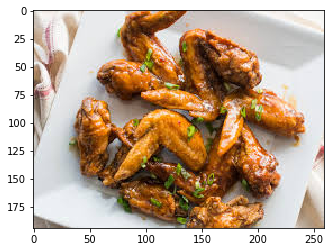

In [22]:
import matplotlib.image as img
pic_path = './chicken-wings.jpg'
test_local = result(pic_path)
#best_pred = collections.Counter(test_local).most_common(1)[0][0]
best_pred = test_local[0]
print(best_pred)

pic = img.imread(pic_path)
plt.imshow(pic)